<a href="https://colab.research.google.com/github/Jax45/Deepfake-Detection/blob/main/Deepfake_Detection_Final_Product.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 5390 Deep Learning UMSL
## Spring 2021 Semester Project
### DeepFake Detection
Jackson Hoenig

# Description

The purpose of this project is to attempt to create a model that can be trained to detect a deepfake video from a real video of my face. It requires about 500 pictures from differing angles, backgrounds, lightings, etc for the dataset, also it requires deepfaked videos' frames as well.

#Initial Setup

##Imports

In [1]:
# !pip install tensorflow==2.2.0
import tensorflow
print(tensorflow.__version__)

2.4.1


In [2]:
import requests, zipfile, io, os
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from keras import layers
from keras import models
from keras import callbacks
from keras.callbacks import ModelCheckpoint
from keras.layers import Dropout
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

In [3]:
#Make sure the Earlystop callback is used with the validation set
callback = callbacks.EarlyStopping(monitor='val_loss', patience=5)

##Prevent Google Colab From Stalling

In [4]:
import IPython
from google.colab import output

display(IPython.display.Javascript('''
 function ClickConnect(){
   btn = document.querySelector("colab-connect-button")
   if (btn != null){
     console.log("Click colab-connect-button"); 
     btn.click() 
     }
   
   btn = document.getElementById('ok')
   if (btn != null){
     console.log("Click reconnect"); 
     btn.click() 
     }
  }
  
setInterval(ClickConnect,60000)
'''))

print("Done.")

<IPython.core.display.Javascript object>

Done.


#Split the Training Data

In [5]:
print('Downloading and unzipping test file.')
r = requests.get('https://github.com/Jax45/Deepfake-Detection/raw/main/DeepfakeDataset-001.zip')
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

In [6]:
#create the directory paths
!mkdir SplitDataset
!mkdir SplitDataset/train
!mkdir SplitDataset/test
!mkdir SplitDataset/valid
!mkdir SplitDataset/train/real
!mkdir SplitDataset/train/fake
!mkdir SplitDataset/test/real
!mkdir SplitDataset/test/fake
!mkdir SplitDataset/valid/real
!mkdir SplitDataset/valid/fake

mkdir: cannot create directory ‘SplitDataset’: File exists
mkdir: cannot create directory ‘SplitDataset/train’: File exists
mkdir: cannot create directory ‘SplitDataset/test’: File exists
mkdir: cannot create directory ‘SplitDataset/valid’: File exists
mkdir: cannot create directory ‘SplitDataset/train/real’: File exists
mkdir: cannot create directory ‘SplitDataset/train/fake’: File exists
mkdir: cannot create directory ‘SplitDataset/test/real’: File exists
mkdir: cannot create directory ‘SplitDataset/test/fake’: File exists
mkdir: cannot create directory ‘SplitDataset/valid/real’: File exists
mkdir: cannot create directory ‘SplitDataset/valid/fake’: File exists


In [7]:
# !rm SplitDataset/train/real/*
# !rm SplitDataset/train/fake/*
# !rm SplitDataset/test/real/*
# !rm SplitDataset/test/fake/*
# !rm SplitDataset/valid/real/*
# !rm SplitDataset/valid/fake/*
# !rmdir SplitDataset/train/real
# !rmdir SplitDataset/train/fake
# !rmdir SplitDataset/test/real
# !rmdir SplitDataset/test/fake
# !rmdir SplitDataset/valid/real
# !rmdir SplitDataset/valid/fake
# !rmdir SplitDataset/train
# !rmdir SplitDataset/test
# !rmdir SplitDataset/valid
# !rmdir -p SplitDataset

In [8]:

#save all real file names to list
import os
count = 0
realFileNames = list()
fakeFileNames = list()
for filename in os.listdir('/content/Real_Images'):
  realFileNames.append(filename)

#save all fake file names to list
for filename in os.listdir('/content/Fake_Images'):
  fakeFileNames.append(filename)



In [9]:
import random
import os
import imageio
#split real file names into
#train valid and test
#random.shuffle(realFileNames)
count = 0
for file in realFileNames:
  if count % 5 == 0 or count % 5 == 2 or count % 5 == 4: #first 60%
    # print("Train dataset" + str(count))
    imageio.imwrite('/content/SplitDataset/train/real/' + file, imageio.imread('/content/Real_Images/' + file))

  elif count % 5 == 1: #20% after 60%
    # print("Valid dataset" + str(count))
    imageio.imwrite('/content/SplitDataset/valid/real/' + file, imageio.imread('/content/Real_Images/' + file))

  else: #Last 20 percent
    #Test
    imageio.imwrite('/content/SplitDataset/test/real/' + file, imageio.imread('/content/Real_Images/' + file))

  count += 1;


With the fake images we need to make sure the same videos are kept together so they do not get split among the datasets. there are 8 videos so we will take the first 4 videos for training, the next 2 for validation and last 2 for test set.

In [10]:
count = 0
for file in fakeFileNames:
  if file.startswith('gen1') or file.startswith('gen3') or file.startswith('gen4') or file.startswith('gen5'): #first 60%
    # print("Train dataset" + str(count) + file)
    imageio.imwrite('/content/SplitDataset/train/fake/' + file, imageio.imread('/content/Fake_Images/' + file))

  elif file.startswith('gen6') or file.startswith('gen7'): #20% after 60%
    # print("Valid dataset" + str(count))
    imageio.imwrite('/content/SplitDataset/valid/fake/' + file, imageio.imread('/content/Fake_Images/' + file))

  else: #Last 20 percent
    #Test
    imageio.imwrite('/content/SplitDataset/test/fake/' + file, imageio.imread('/content/Fake_Images/' + file))
  
  count += 1;


In [11]:
base_dir = 'SplitDataset'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

for s in os.listdir(base_dir):
  for origin in os.listdir(base_dir+'/'+s):
    print(base_dir+'/'+s+'/'+origin+': '+str(len(os.listdir(base_dir+'/'+s+'/'+origin))))
  print('-----')

SplitDataset/test/fake: 73
SplitDataset/test/real: 100
-----
SplitDataset/valid/fake: 73
SplitDataset/valid/real: 101
-----
SplitDataset/train/fake: 215
SplitDataset/train/real: 302
-----


In [12]:
#Add imbalence library.
#GNN better than CNN.
#see all misclassified images.
#

In [13]:
print(train_dir)
print(validation_dir)
print(test_dir)

SplitDataset/train
SplitDataset/valid
SplitDataset/test


## Create Data Generators

In [14]:
#get a validation set generator
train_datagen = ImageDataGenerator(rescale=1./255,
    fill_mode='nearest',
    rotation_range=10,
    height_shift_range=0.2,
    width_shift_range=0.2
    )

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(256, 256),
        batch_size=4,
        class_mode='categorical')
class_dictionary = train_generator.class_indices
print(class_dictionary)

Found 517 images belonging to 2 classes.
{'fake': 0, 'real': 1}


In [15]:
#get a validation set generator
validate_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validate_datagen.flow_from_directory(
        validation_dir,
        target_size=(256, 256),
        batch_size=4,
        class_mode='categorical')

Found 174 images belonging to 2 classes.


In [16]:
#get a test set generator
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(256, 256),
        batch_size=20,
        class_mode='categorical')

Found 173 images belonging to 2 classes.


Found 517 images belonging to 2 classes.


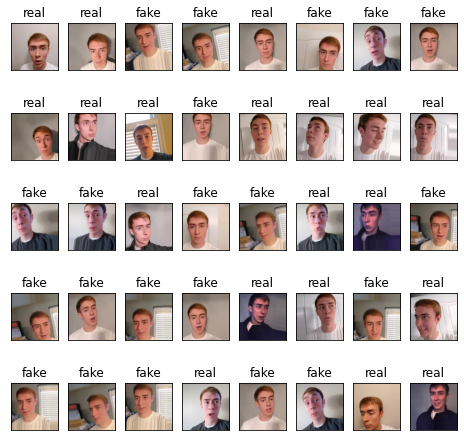

In [17]:
i = 0
figure = plt.figure(figsize=(8, 8))
columns = 8
rows = 5
ax = []
for batch in train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 256x256
        target_size=(256, 256),
        batch_size=1,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical'):
    i += 1
    lbl_index = np.nonzero(batch[1][0] == 1)[0][0]
    label = list(class_dictionary.keys())[list(class_dictionary.values()).index(lbl_index)]
    
    ax.append( figure.add_subplot(rows, columns, i) )
    imgplot = plt.imshow(image.array_to_img(batch[0][0,:,:,:]),cmap='gray')
    ax[-1].set_title(label)  # set title
    
    if i % (columns*rows) == 0:
        break
plt.setp(ax, xticks=[], yticks=[])
    
plt.show()

Found 174 images belonging to 2 classes.


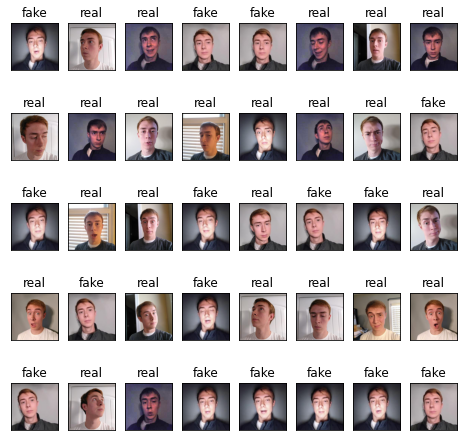

In [18]:
i = 0
figure = plt.figure(figsize=(8, 8))
columns = 8
rows = 5
ax = []
for batch in validate_datagen.flow_from_directory(
        # This is the target directory
        validation_dir,
        # All images will be resized to 256x256
        target_size=(256, 256),
        batch_size=1,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical'):
    i += 1
    lbl_index = np.nonzero(batch[1][0] == 1)[0][0]
    label = list(class_dictionary.keys())[list(class_dictionary.values()).index(lbl_index)]
    
    ax.append( figure.add_subplot(rows, columns, i) )
    imgplot = plt.imshow(image.array_to_img(batch[0][0,:,:,:]),cmap='gray')
    ax[-1].set_title(label)  # set title
    
    if i % (columns*rows) == 0:
        break
plt.setp(ax, xticks=[], yticks=[])
    
plt.show()

#Previous Phase Best Model
In the previous project phases we found that the best architechture was the VGG16 base model with a dropout of .5. Variations will be tested to see if this is still the best.

##VGG16

In [19]:
from tensorflow.keras.applications.vgg16 import VGG16
VGmodel = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))


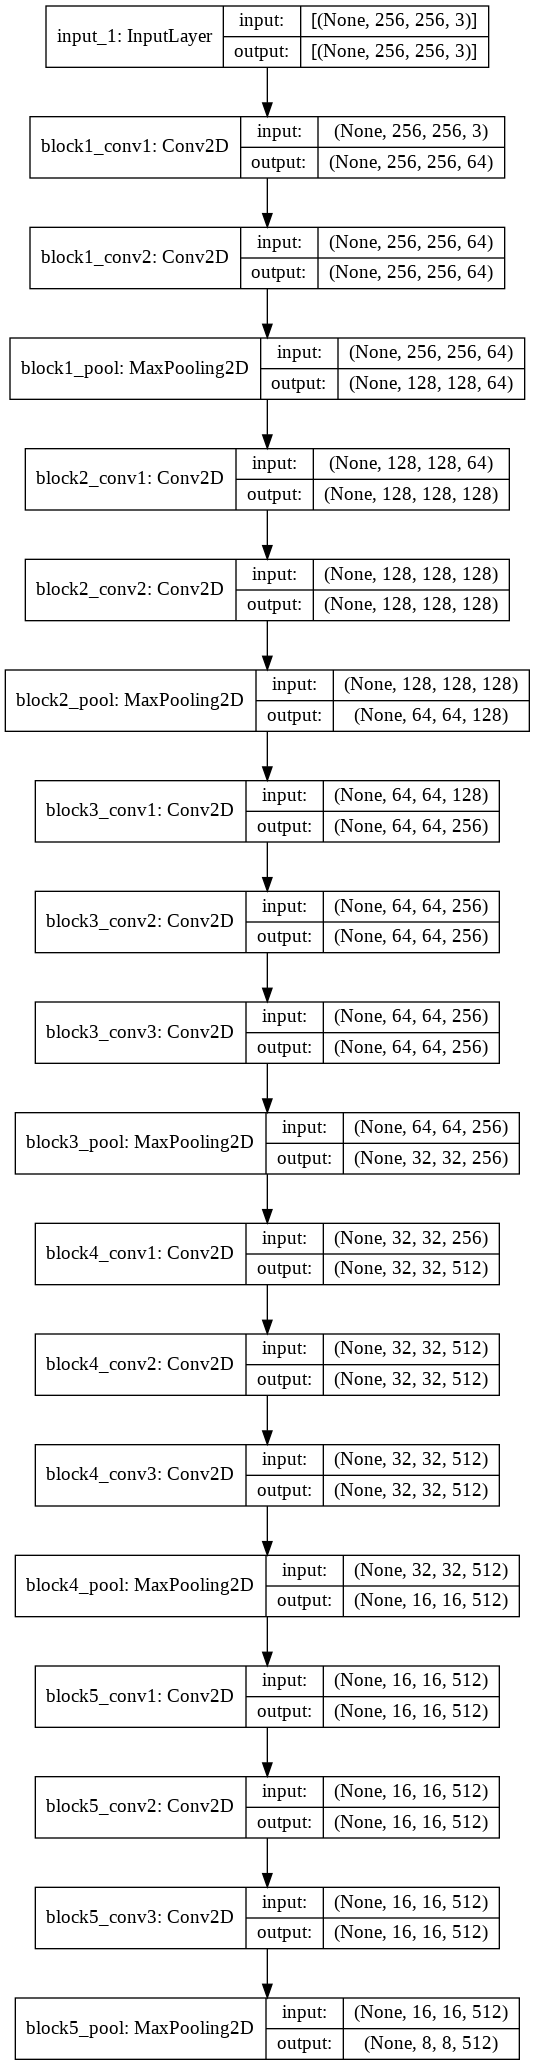

In [20]:
from tensorflow.keras.utils import plot_model
plot_model(VGmodel, show_layer_names=True, show_shapes=True)

In [21]:
# Empty placeholders for 400 Grayscale images and their labels
x_train = np.zeros((400, 256, 256, 3))
y_train = np.zeros((400, 2))
# Read everything from your generator
i = 0;
j = 0;
maxI = 400 / 4
for x, y in train_generator:
  #  print(x.shape)
  #  print(y)
  #  print(mydatax[j, :, :].shape)
   x_train[j] = x[0]
   y_train[j] = y[0]
   j+=1
   x_train[j] = x[1]
   y_train[j] = y[1]
   j+=1
   x_train[j] = x[2]
   y_train[j] = y[2]
   j+=1
   x_train[j] = x[3]
   y_train[j] = y[3]
   j+=1
   i+=1
   if i == maxI:
     break

In [22]:
# Empty placeholders for 400 Grayscale images and their labels
x_valid = np.zeros((400, 256, 256, 3))
y_valid = np.zeros((400, 2))
# Read everything from your generator
i = 0;
j = 0;
maxI = 400 / 4
for x, y in test_generator:
  #  print(x.shape)
  #  print(y)
  #  print(mydatax[j, :, :].shape)
   x_valid[j] = x[0]
   y_valid[j] = y[0]
   j+=1
   x_valid[j] = x[1]
   y_valid[j] = y[1]
   j+=1
   x_valid[j] = x[2]
   y_valid[j] = y[2]
   j+=1
   x_valid[j] = x[3]
   y_valid[j] = y[3]
   j+=1
   i+=1
   if i == maxI:
     break

In [23]:
# Empty placeholders for 400 Grayscale images and their labels
x_test = np.zeros((400, 256, 256, 3))
y_test = np.zeros((400, 2))
# Read everything from your generator
i = 0;
j = 0;
maxI = 400 / 4
for x, y in test_generator:
  #  print(x.shape)
  #  print(y)
  #  print(mydatax[j, :, :].shape)
   x_test[j] = x[0]
   y_test[j] = y[0]
   j+=1
   x_test[j] = x[1]
   y_test[j] = y[1]
   j+=1
   x_test[j] = x[2]
   y_test[j] = y[2]
   j+=1
   x_test[j] = x[3]
   y_test[j] = y[3]
   j+=1
   i+=1
   if i == maxI:
     break

In [24]:
x_test_vgg_output = VGmodel.predict(x_test, verbose = 1)
x_valid_vgg_output = VGmodel.predict(x_valid, verbose = 1)
x_train_vgg_output = VGmodel.predict(x_train, verbose = 1)

13/13 [==============================] - 2s 152ms/step


In [25]:

print(x_test_vgg_output.shape)
print(x_train_vgg_output.shape)
print(y_train.shape)
print(y_test.shape)

(400, 8, 8, 512)
(400, 8, 8, 512)
(400, 2)
(400, 2)


In [26]:
import numpy as np
x_valid_new = np.reshape(x_valid_vgg_output, (400, 8 * 8 * 512))
x_test_new = np.reshape(x_test_vgg_output, (400, 8 * 8* 512))
x_train_new = np.reshape(x_train_vgg_output, (400, 8 * 8 * 512))


In [27]:
print(x_test_new.shape)
print(x_train_new.shape)

(400, 32768)
(400, 32768)


In [28]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

new_model = models.Sequential()
new_model.add(layers.Dense(256, activation='relu', input_dim = 8 * 8 * 512))
new_model.add(layers.Dropout(0.5))
new_model.add(layers.Dense(2, activation='sigmoid'))

new_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
history = new_model.fit(x_train_new, y_train, epochs=128, batch_size=128, validation_data = (x_valid_new, y_valid))

Epoch 1/128
4/4 [==============================] - 1s 158ms/step - loss: 19.0147 - accuracy: 0.5236 - val_loss: 6.1047 - val_accuracy: 0.4325
Epoch 2/128
4/4 [==============================] - 0s 33ms/step - loss: 3.8412 - accuracy: 0.5529 - val_loss: 1.1975 - val_accuracy: 0.3950
Epoch 3/128
4/4 [==============================] - 0s 32ms/step - loss: 1.2801 - accuracy: 0.6070 - val_loss: 1.1756 - val_accuracy: 0.3750
Epoch 4/128
4/4 [==============================] - 0s 33ms/step - loss: 0.7504 - accuracy: 0.6626 - val_loss: 1.3630 - val_accuracy: 0.6500
Epoch 5/128
4/4 [==============================] - 0s 31ms/step - loss: 0.3183 - accuracy: 0.8595 - val_loss: 1.7785 - val_accuracy: 0.5675
Epoch 6/128
4/4 [==============================] - 0s 30ms/step - loss: 0.3129 - accuracy: 0.8437 - val_loss: 2.0311 - val_accuracy: 0.5675
Epoch 7/128
4/4 [==============================] - 0s 32ms/step - loss: 0.3336 - accuracy: 0.8467 - val_loss: 1.7773 - val_accuracy: 0.5675
Epoch 8/128
4/4 [=

# Data Augmentation

In [29]:
#Adding a rotation range of 40 degrees
train_datagen1 = ImageDataGenerator(rescale=1./255,
    rotation_range=40
    )

train_generator1 = train_datagen1.flow_from_directory(
        train_dir,
        target_size=(256, 256),
        batch_size=4,
        class_mode='categorical')

#adding a width_shift_range of 0.2
train_datagen2 = ImageDataGenerator(rescale=1./255,
    width_shift_range=0.2
    )

train_generator2 = train_datagen2.flow_from_directory(
        train_dir,
        target_size=(256, 256),
        batch_size=4,
        class_mode='categorical')
#adding a height shift range of 0.2
train_datagen3 = ImageDataGenerator(rescale=1./255,
    height_shift_range=0.2
    )

train_generator3 = train_datagen3.flow_from_directory(
        train_dir,
        target_size=(256, 256),
        batch_size=4,
        class_mode='categorical')
#adding a shear range of 0.2
train_datagen4 = ImageDataGenerator(rescale=1./255,
    shear_range=0.2
    )

train_generator4 = train_datagen4.flow_from_directory(
        train_dir,
        target_size=(256, 256),
        batch_size=4,
        class_mode='categorical')
#adding a zoom_range of 0.2
train_datagen5 = ImageDataGenerator(rescale=1./255,
    zoom_range=0.2
    )

train_generator5 = train_datagen5.flow_from_directory(
        train_dir,
        target_size=(256, 256),
        batch_size=4,
        class_mode='categorical')
#adding a horizontal flip=true
train_datagen6 = ImageDataGenerator(rescale=1./255,
    horizontal_flip=True
    )

train_generator6 = train_datagen6.flow_from_directory(
        train_dir,
        target_size=(256, 256),
        batch_size=4,
        class_mode='categorical')
#adding fill_mode='nearest'
train_datagen7 = ImageDataGenerator(rescale=1./255,
    fill_mode='nearest'
    )

train_generator7 = train_datagen7.flow_from_directory(
        train_dir,
        target_size=(256, 256),
        batch_size=4,
        class_mode='categorical')

#adding fill_mode='nearest' and     height_shift_range=0.2

train_datagen8 = ImageDataGenerator(rescale=1./255,
    fill_mode='nearest',
    height_shift_range=0.2
    )

train_generator8 = train_datagen8.flow_from_directory(
        train_dir,
        target_size=(256, 256),
        batch_size=4,
        class_mode='categorical')
   



#adding the previous augmentations from the original generator.
train_datagen9 = ImageDataGenerator(rescale=1./255,
    fill_mode='nearest',
    rotation_range=10,
    height_shift_range=0.2
    )

train_generator9 = train_datagen9.flow_from_directory(
        train_dir,
        target_size=(256, 256),
        batch_size=4,
        class_mode='categorical')

train_datagen10 = ImageDataGenerator(rescale=1./255,
    fill_mode='nearest',
    rotation_range=10,
    brightness_range=[0.8,1.2],
    height_shift_range=0.2
    )

train_generator10 = train_datagen10.flow_from_directory(
        train_dir,
        target_size=(256, 256),
        batch_size=4,
        class_mode='categorical')

#best combined?
train_datagen11 = ImageDataGenerator(rescale=1./255,
    fill_mode='nearest',
    rotation_range=10,
    height_shift_range=0.2,
    width_shift_range=0.2
    )

train_generator11 = train_datagen11.flow_from_directory(
        train_dir,
        target_size=(256, 256),
        batch_size=4,
        class_mode='categorical')

#all
train_datagen12 = ImageDataGenerator(rescale=1./255,
    fill_mode='nearest',
    rotation_range=10,
    height_shift_range=0.2,
    width_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8,1.2]
    )

train_generator12 = train_datagen12.flow_from_directory(
        train_dir,
        target_size=(256, 256),
        batch_size=4,
        class_mode='categorical')


Found 517 images belonging to 2 classes.
Found 517 images belonging to 2 classes.
Found 517 images belonging to 2 classes.
Found 517 images belonging to 2 classes.
Found 517 images belonging to 2 classes.
Found 517 images belonging to 2 classes.
Found 517 images belonging to 2 classes.
Found 517 images belonging to 2 classes.
Found 517 images belonging to 2 classes.
Found 517 images belonging to 2 classes.
Found 517 images belonging to 2 classes.
Found 517 images belonging to 2 classes.


## Test the VGG16 model on all data generators.

16/16 [==============================] - 7s 459ms/step


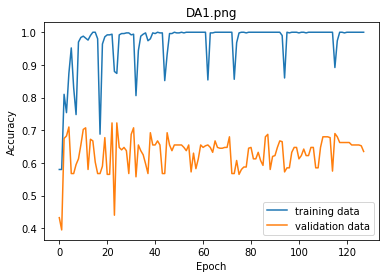

___________________________________
DAModel1
testing_acc: 0.737500011920929
testing_loss: 1.692570447921753
16/16 [==============================] - 2s 155ms/step


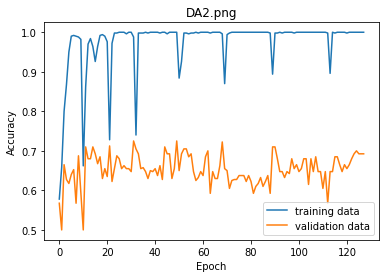

___________________________________
DAModel2
testing_acc: 0.7450000047683716
testing_loss: 2.6440985202789307
16/16 [==============================] - 2s 155ms/step


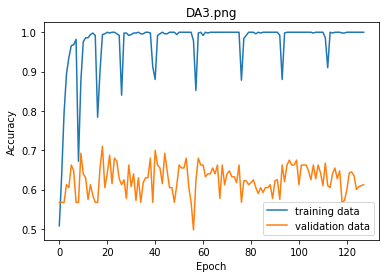

___________________________________
DAModel3
testing_acc: 0.7350000143051147
testing_loss: 2.7468907833099365
16/16 [==============================] - 2s 155ms/step


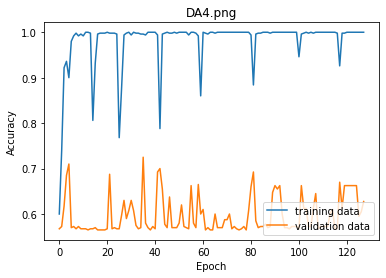

___________________________________
DAModel4
testing_acc: 0.7450000047683716
testing_loss: 3.0831897258758545
16/16 [==============================] - 2s 155ms/step


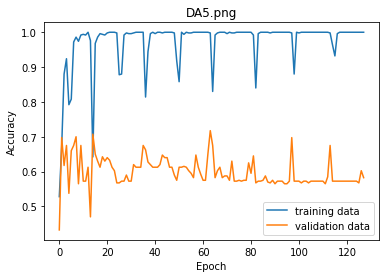

___________________________________
DAModel5
testing_acc: 0.7325000166893005
testing_loss: 4.766064643859863
16/16 [==============================] - 2s 156ms/step


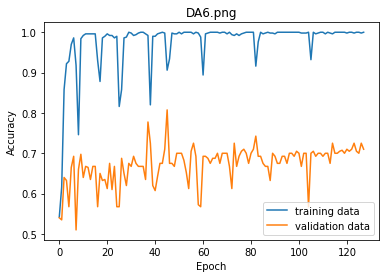

___________________________________
DAModel6
testing_acc: 0.8224999904632568
testing_loss: 0.5480125546455383
16/16 [==============================] - 2s 156ms/step


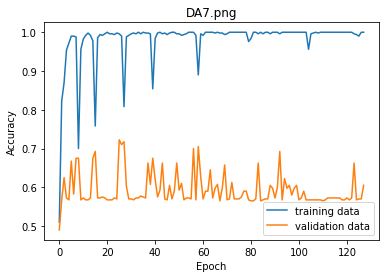

___________________________________
DAModel7
testing_acc: 0.737500011920929
testing_loss: 3.1313257217407227
16/16 [==============================] - 2s 155ms/step


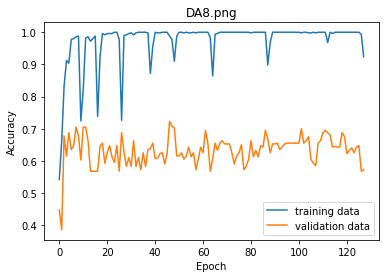

___________________________________
DAModel8
testing_acc: 0.737500011920929
testing_loss: 2.4128127098083496
16/16 [==============================] - 2s 157ms/step


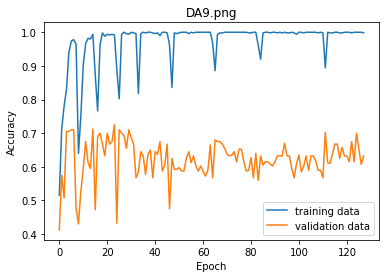

___________________________________
DAModel9
testing_acc: 0.7450000047683716
testing_loss: 2.339217185974121
16/16 [==============================] - 2s 156ms/step


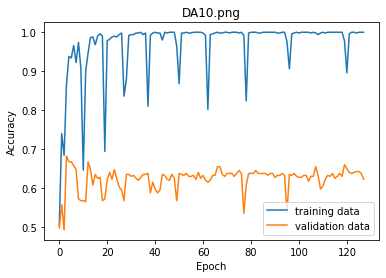

___________________________________
DAModel10
testing_acc: 0.7099999785423279
testing_loss: 3.030808687210083
16/16 [==============================] - 2s 157ms/step


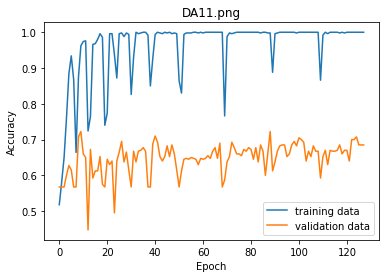

___________________________________
DAModel11
testing_acc: 0.737500011920929
testing_loss: 2.3395140171051025
16/16 [==============================] - 2s 154ms/step


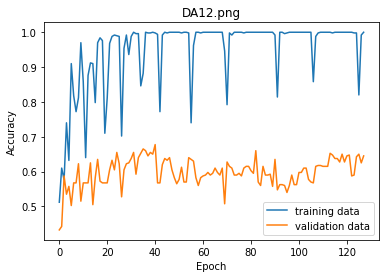

___________________________________
DAModel12
testing_acc: 0.6924999952316284
testing_loss: 2.360452651977539


<Figure size 432x288 with 0 Axes>

In [30]:
#get the numpy arrays of the generators
modelNum = -1; # model number
gens = list((train_generator1,train_generator2,train_generator3,train_generator4,train_generator5,train_generator6,train_generator7,train_generator8,train_generator9,train_generator10,train_generator11,train_generator12))
DAmodel1 = models.Sequential()
DAmodel2 = models.Sequential()
DAmodel3 = models.Sequential()
DAmodel4 = models.Sequential()
DAmodel5 = models.Sequential()
DAmodel6 = models.Sequential()
DAmodel7 = models.Sequential()
DAmodel8 = models.Sequential()
DAmodel9 = models.Sequential()
DAmodel10 = models.Sequential()
DAmodel11 = models.Sequential()
DAmodel12 = models.Sequential()
DAModels = list((DAmodel1,DAmodel2,DAmodel3,DAmodel4,DAmodel5,DAmodel6,DAmodel7,DAmodel8,DAmodel9,DAmodel10,DAmodel11,DAmodel12))


for gen in gens:
  imgNum = 500
  # Empty placeholders for imgNum Grayscale images and their labels
  x_train = np.zeros((imgNum, 256, 256, 3))
  y_train = np.zeros((imgNum, 2))
  # Read everything from your generator
  i = 0;
  j = 0;
  maxI = imgNum / 4
  for x, y in gen:
    #  print(x.shape)
    #  print(y)
    #  print(mydatax[j, :, :].shape)
    x_train[j] = x[0]
    y_train[j] = y[0]
    j+=1
    x_train[j] = x[1]
    y_train[j] = y[1]
    j+=1
    x_train[j] = x[2]
    y_train[j] = y[2]
    j+=1
    x_train[j] = x[3]
    y_train[j] = y[3]
    j+=1
    i+=1
    if i == maxI:
      break
  
  #now we train the model
  modelNum += 1;
  x_train_vgg_output = VGmodel.predict(x_train, verbose = 1)
  x_train_new = np.reshape(x_train_vgg_output, (imgNum, 8 * 8 * 512))
  DAModels[modelNum].add(layers.Dense(256, activation='relu', input_dim = 8 * 8 * 512))
  DAModels[modelNum].add(layers.Dropout(0.5))
  DAModels[modelNum].add(layers.Dense(2, activation='sigmoid'))

  #add checkpointing
  checkpoint_filepath = '/tmp/checkpoint'
  model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


  DAModels[modelNum].compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
  historyDA = DAModels[modelNum].fit(x_train_new, y_train, verbose=0, callbacks=[model_checkpoint_callback], epochs=128, batch_size=128, validation_data = (x_valid_new, y_valid))

  #get best model
  DAModels[modelNum].load_weights(checkpoint_filepath)

  #show the training plot and save it
  plt.plot(historyDA.history['accuracy'])
  plt.plot(historyDA.history['val_accuracy'])
  plt.title('DA'+str(modelNum+1)+'.png')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['training data', 'validation data'], loc='lower right')
  plt.show()
  plt.savefig("DA"+str(modelNum+1)+".png")

  #test dataset
  testing_loss, testing_acc =DAModels[modelNum].evaluate(x_test_new, y_test, max_queue_size=10, steps=9, workers=1, use_multiprocessing=False, verbose=0)
  print("___________________________________")
  print("DAModel"+str(modelNum+1))
  print( 'testing_acc:', testing_acc )
  print( 'testing_loss:', testing_loss )
  print("===================================")

From this we see that Model 6 got the best testing accuracy with a unseen before 82%! that datagenerator seems to be the best.

In [31]:
train_datagen_best = ImageDataGenerator(rescale=1./255,
    horizontal_flip=True
    )

train_generator_best = train_datagen_best.flow_from_directory(
        train_dir,
        target_size=(256, 256),
        batch_size=4,
        class_mode='categorical')

imgNum = 500
# Empty placeholders for imgNum Grayscale images and their labels
x_train = np.zeros((imgNum, 256, 256, 3))
y_train = np.zeros((imgNum, 2))
# Read everything from your generator
i = 0;
j = 0;
maxI = imgNum / 4
for x, y in train_generator_best:
  #  print(x.shape)
  #  print(y)
  #  print(mydatax[j, :, :].shape)
  x_train[j] = x[0]
  y_train[j] = y[0]
  j+=1
  x_train[j] = x[1]
  y_train[j] = y[1]
  j+=1
  x_train[j] = x[2]
  y_train[j] = y[2]
  j+=1
  x_train[j] = x[3]
  y_train[j] = y[3]
  j+=1
  i+=1
  if i == maxI:
    break

#our inputs
x_train_vgg_output = VGmodel.predict(x_train, verbose = 1)
x_train_new = np.reshape(x_train_vgg_output, (imgNum, 8 * 8 * 512))

Found 517 images belonging to 2 classes.
16/16 [==============================] - 2s 154ms/step


# Regularization
## Because we know that VGG16 model worked really well we are going to try variations on that model and see what improvements we can find with our other ideas.

16/16 [==============================] - 3s 178ms/step


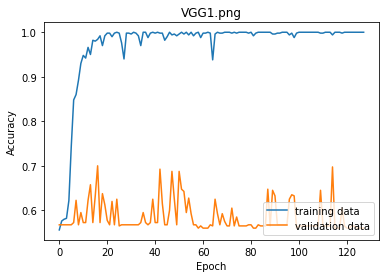

___________________________________
VGGModel1
testing_acc: 0.7300000190734863
testing_loss: 1.0181101560592651
16/16 [==============================] - 3s 179ms/step


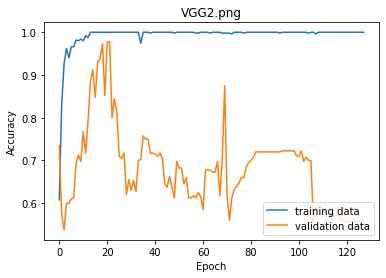

___________________________________
VGGModel2
testing_acc: 0.9725000262260437
testing_loss: 0.12900559604167938
16/16 [==============================] - 3s 177ms/step


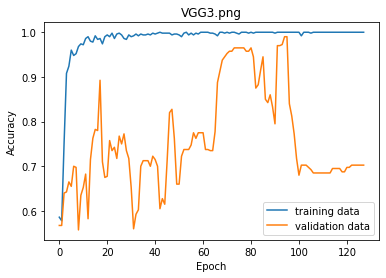

___________________________________
VGGModel3
testing_acc: 0.987500011920929
testing_loss: 0.08994770795106888
16/16 [==============================] - 3s 177ms/step


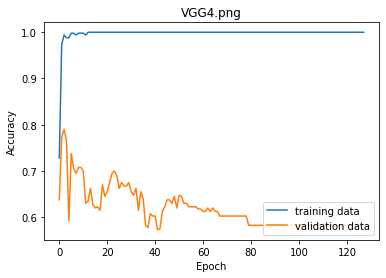

___________________________________
VGGModel4
testing_acc: 0.8100000023841858
testing_loss: 0.5281137228012085
16/16 [==============================] - 3s 178ms/step


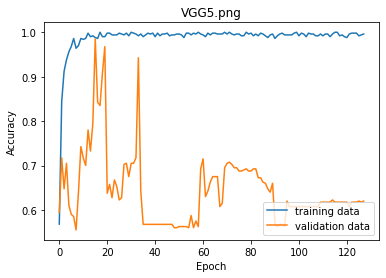

___________________________________
VGGModel5
testing_acc: 0.9850000143051147
testing_loss: 0.11530213057994843
16/16 [==============================] - 3s 176ms/step


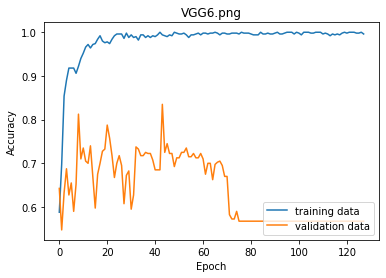

___________________________________
VGGModel6
testing_acc: 0.8349999785423279
testing_loss: 0.8794384002685547
16/16 [==============================] - 3s 177ms/step


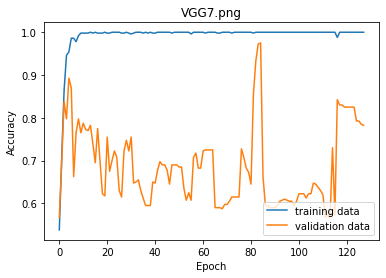

___________________________________
VGGModel7
testing_acc: 0.9750000238418579
testing_loss: 0.19405816495418549
16/16 [==============================] - 3s 177ms/step


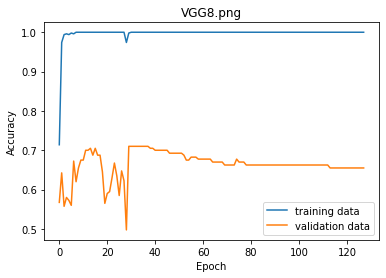

___________________________________
VGGModel8
testing_acc: 0.7250000238418579
testing_loss: 1.3131697177886963


<Figure size 432x288 with 0 Axes>

In [39]:
#get the numpy arrays of the generators
modelNum = -1; # model number
VGGmodel1 = models.Sequential()
VGGmodel1.add(layers.Dense(256, activation='relu', input_dim = 8 * 8 * 512))
VGGmodel1.add(layers.Dropout(0.5))
VGGmodel1.add(layers.Dense(2, activation='sigmoid'))
VGGmodel1.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

#.4 dropout resulted in 90+% acc
VGGmodel2 = models.Sequential()
VGGmodel2.add(layers.Dense(256, activation='relu', input_dim = 8 * 8 * 512))
VGGmodel2.add(BatchNormalization())
VGGmodel2.add(layers.Dense(20, activation='relu'))
VGGmodel2.add(layers.Dropout(0.4))
VGGmodel2.add(layers.Dense(2, activation='sigmoid'))
VGGmodel2.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

#change to .5 dropout
VGGmodel3 = models.Sequential()
VGGmodel3.add(layers.Dense(256, activation='relu', input_dim = 8 * 8 * 512))
VGGmodel3.add(BatchNormalization())
VGGmodel3.add(layers.Dense(20, activation='relu'))
VGGmodel3.add(layers.Dropout(0.5))
VGGmodel3.add(layers.Dense(2, activation='sigmoid'))
VGGmodel3.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

VGGmodel4 = models.Sequential()
VGGmodel4.add(layers.Dense(256, activation='relu', input_dim = 8 * 8 * 512))
VGGmodel4.add(BatchNormalization())
VGGmodel4.add(layers.Dense(40, activation='relu'))
VGGmodel4.add(layers.Dropout(0.4))
VGGmodel4.add(layers.Dense(2, activation='sigmoid'))
VGGmodel4.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

VGGmodel5 = models.Sequential()
VGGmodel5.add(layers.Dense(256, activation='relu', input_dim = 8 * 8 * 512))
VGGmodel5.add(BatchNormalization())
VGGmodel5.add(layers.Dense(10, activation='relu'))
VGGmodel5.add(layers.Dropout(0.4))
VGGmodel5.add(layers.Dense(2, activation='sigmoid'))
VGGmodel5.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

VGGmodel6 = models.Sequential()
VGGmodel6.add(layers.Dense(256, activation='relu', input_dim = 8 * 8 * 512))
VGGmodel6.add(BatchNormalization())
VGGmodel6.add(layers.Dense(20, activation='relu'))
VGGmodel6.add(layers.Dense(10, activation='relu'))
VGGmodel6.add(layers.Dropout(0.4))
VGGmodel6.add(layers.Dense(2, activation='sigmoid'))
VGGmodel6.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

VGGmodel7 = models.Sequential()
VGGmodel7.add(layers.Dense(256, activation='relu', input_dim = 8 * 8 * 512))
VGGmodel7.add(BatchNormalization())
VGGmodel7.add(layers.Dense(20, activation='relu'))
VGGmodel7.add(layers.Dropout(0.4))
VGGmodel7.add(layers.Dense(2, activation='relu'))
VGGmodel7.add(layers.Dense(2, activation='sigmoid'))
VGGmodel7.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

VGGmodel8 = models.Sequential()
VGGmodel8.add(layers.Dense(256, activation='relu', input_dim = 8 * 8 * 512))
VGGmodel8.add(BatchNormalization())
VGGmodel8.add(layers.Dense(64, activation='relu'))
VGGmodel8.add(layers.Dropout(0.4))
VGGmodel8.add(layers.Dense(2, activation='sigmoid'))
VGGmodel8.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

VGGModels = list((VGGmodel1,VGGmodel2,VGGmodel3,VGGmodel4,VGGmodel5,VGGmodel6,VGGmodel7,VGGmodel8))

for model in VGGModels:
  #now we train the model
  modelNum += 1;
  x_train_vgg_output = VGmodel.predict(x_train, verbose = 1)
  x_train_new = np.reshape(x_train_vgg_output, (imgNum, 8 * 8 * 512))
  VGGModels[modelNum].add(layers.Dense(256, activation='relu', input_dim = 8 * 8 * 512))
  VGGModels[modelNum].add(layers.Dropout(0.5))
  VGGModels[modelNum].add(layers.Dense(2, activation='sigmoid'))

  #add checkpointing
  checkpoint_filepath = '/tmp/checkpoint'
  model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


  historyVGG = VGGModels[modelNum].fit(x_train_new, y_train, verbose=0, callbacks=[model_checkpoint_callback], epochs=128, batch_size=128, validation_data = (x_valid_new, y_valid))

  #get best model
  VGGModels[modelNum].load_weights(checkpoint_filepath)

  #show the training plot and save it
  plt.plot(historyVGG.history['accuracy'])
  plt.plot(historyVGG.history['val_accuracy'])
  plt.title('VGG'+str(modelNum+1)+'.png')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['training data', 'validation data'], loc='lower right')
  plt.show()
  plt.savefig("VGG"+str(modelNum+1)+".png")

  #test dataset
  testing_loss, testing_acc =VGGModels[modelNum].evaluate(x_test_new, y_test, max_queue_size=10, steps=9, workers=1, use_multiprocessing=False, verbose=0)
  print("___________________________________")
  print("VGGModel"+str(modelNum+1))
  print( 'testing_acc:', testing_acc )
  print( 'testing_loss:', testing_loss )
  print("===================================")

# Results
Starting with a baseline of 58% on the testing set, A model with VGG16 base was created and trained with a 72% accuracy on the testing set.

We found out that the best data augmentation was a simple horizontal flip from the data augmentations and this updated the same model with an accuracy of 82%.

Finally, adding regularization layers with BatchNormalization gave us a model with a testing accuracy of 98.75%! This is very good.

The final model configuration is below with its evaluation.

In [44]:



#config:
print("Configuration:")
print("VGGmodel3 = models.Sequential()")
print("VGGmodel3.add(layers.Dense(256, activation='relu', input_dim = 8 * 8 * 512))")
print("VGGmodel3.add(BatchNormalization())")
print("VGGmodel3.add(layers.Dense(20, activation='relu'))")
print("VGGmodel3.add(layers.Dropout(0.5))")
print("VGGmodel3.add(layers.Dense(2, activation='sigmoid'))")
print("VGGmodel3.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])")

#Evaluation
print("Evaluation on Test set")
testing_loss, testing_acc =VGGModels[2].evaluate(x_test_new, y_test, max_queue_size=10, steps=9, workers=1, use_multiprocessing=False, verbose=0)
print("___________________________________")
print("VGGModel"+str(2+1))
print( 'testing_acc:', testing_acc )
print( 'testing_loss:', testing_loss )
print("===================================")

Configuration:
VGGmodel3 = models.Sequential()
VGGmodel3.add(layers.Dense(256, activation='relu', input_dim = 8 * 8 * 512))
VGGmodel3.add(BatchNormalization())
VGGmodel3.add(layers.Dense(20, activation='relu'))
VGGmodel3.add(layers.Dropout(0.5))
VGGmodel3.add(layers.Dense(2, activation='sigmoid'))
VGGmodel3.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
Evaluation on Test set
___________________________________
VGGModel3
testing_acc: 0.987500011920929
testing_loss: 0.08994770795106888


# Save Model

In [45]:
VGGModels[2].save('deepfake_detection_jth.h5')

In [47]:
from google.colab import files
#download:
#files.download("VGG3.png") 

files.download("deepfake_detection_jth.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>